In [325]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import allan_variance
np.random.seed(0)
import pandas as pd

In [326]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [327]:
def cross_dot(b):
    # d(axb)/d(a)
    cross_dot = np.array([[0, b[2], -b[1]],
                    [-b[2], 0, b[0]],
                    [b[1], -b[0], 0]])
    return cross_dot

def cross2_dot(a, b):
    #d(ax(axb))/d(a)
    cross2_dot = np.array([[a[1]*b[1]+a[2]*b[2], a[0]*b[1]-2*a[1]*b[0], a[0]*b[2]-2*a[2]*b[0]],
                           [-2*a[0]*b[1]+a[1]*b[0], a[0]*b[0]+a[2]*b[2], a[1]*b[2]-2*a[2]*b[1]],
                           [-2*a[0]*b[2]+a[2]*b[0], -2*a[1]*b[2]+a[2]*b[1], a[0]*b[0]+a[1]*b[1]]])
    return cross2_dot
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [328]:
def dynamics(dt, state, RW, w_input_noise):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW[3:6] * np.random.randn(3)    # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                             # omega_dot
    state_next[6:9] = state[6:9] + RW[0:3] * np.random.randn(3)                      # specific force
    return state_next

def dynamics_est(dt, state):
    state_next = np.zeros(9)
    state_next[0:3] = state[0:3] + state[3:6] * dt          # omega
    state_next[3:6] = np.zeros(3)                           # omega_dot
    state_next[6:9] = state[6:9]                                    # specific force
    return state_next

def Jacobian_f(dt):
    F = np.zeros((9, 9))
    F[0:3, 0:3]            = np.eye(3)
    F[0:3, 3:6]            = dt * np.eye(3)
    return F

In [329]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3))
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3)
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    H = np.zeros((6*num_imus, 9))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        H_i = np.zeros((6, 9))
        H_i[0:3, 0:3] = Rb_si_sub @ cross2_dot(omega, r_sub)
        H_i[0:3, 3:6] = Rb_si_sub @ cross_dot(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[3:6, 0:3] = Rb_si_sub
        meas[i*6:6+i*6] = H_i @ state
        H[i*6:6+i*6, :] = H_i
    return meas, H

Simulated measurements

In [330]:
# measurements
measurements = np.array(read_txt("../data/imu18.txt"))
num_imus = 18

'Real' measurements

In [331]:
# imu_paths = [f'../data/Flight_hardware/stochastic_cal_DB{i}.csv' for i in range(1, 7)]

# dfs = [pd.read_csv(path) for path in imu_paths]

# dt = 0.002
# len_time = 360
# time = np.arange(0, len_time, dt)
# num_data = int(len_time / dt)

# df_data = []
# for df in dfs:
#     gx = np.array(df['gx'][1000:num_data+1000])
#     gy = np.array(df['gy'][1000:num_data+1000])
#     gz = np.array(df['gz'][1000:num_data+1000])
#     ax = np.array(df['ax'][1000:num_data+1000])
#     ay = np.array(df['ay'][1000:num_data+1000])
#     az = np.array(df['az'][1000:num_data+1000])
#     df_data.append(np.array([ax, ay, az, gx, gy, gz]))

# for df in dfs:
#     gx = np.array(df['gx'][1000:num_data+1000])
#     gy = np.array(df['gy'][1000:num_data+1000])
#     gz = np.array(df['gz'][1000:num_data+1000])
#     ax = np.array(df['ax'][1000:num_data+1000])
#     ay = np.array(df['ay'][1000:num_data+1000])
#     az = np.array(df['az'][1000:num_data+1000])
#     df_data.append(np.array([ax, ay, az, gx, gy, gz]))


# df = df_data

The parameters of individiual sensors that are estimated from Allan variance curve

In [332]:
# accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z

# df1_WN = np.array([4.704, 4.516, 5.270, 5.725, 5.497, 5.598]) * 1e-3
# df2_WN = np.array([4.826, 4.529, 5.156, 5.765, 5.687, 5.525]) * 1e-3
# df3_WN = np.array([4.772, 4.531, 5.379, 5.131, 5.188, 5.407]) * 1e-3
# df4_WN = np.array([4.813, 4.589, 5.246, 5.378, 5.427, 5.023]) * 1e-3
# df5_WN = np.array([4.820, 4.654, 5.366, 5.460, 5.529, 5.263]) * 1e-3
# df6_WN = np.array([4.729, 4.563, 5.394, 5.181, 5.327, 5.419]) * 1e-3
# df_WN  = np.array([df1_WN, df2_WN, df3_WN, df4_WN, df5_WN, df6_WN, df1_WN, df2_WN, df3_WN, df4_WN, df5_WN, df6_WN]).flatten()

# df1_RW = np.array([    0,    0, 4.33,    0, 6.99, 0]) * 1e-4
# df2_RW = np.array([    0, 4.55,    0,    0, 1.18, 0]) * 1e-4
# df3_RW = np.array([    0, 1.72,    0, 4.19, 7.32, 0]) * 1e-4
# df4_RW = np.array([    0, 6.46, 2.46, 8.32,    0, 0]) * 1e-4
# df5_RW = np.array([ 1.43, 3.47, 6.82,    0,    0, 0]) * 1e-4
# df6_RW = np.array([ 4.19, 1.41, 5.60, 5.12,    0, 0]) * 1e-4
# df_RW = np.stack([df1_RW, df2_RW, df3_RW, df4_RW, df5_RW, df6_RW, df1_RW, df2_RW, df3_RW, df4_RW, df5_RW, df6_RW])

In [333]:
filename = "../data/EKF.txt"

# Rb  = []
# pos = []
# WN  = []
# measurements = []
# for j in range(num_imus):
#     # pos.append(np.random.rand(3)) # position of jth imu in DISIMU
#     Rb.append(np.eye(3)) # orientation of jth imu in DISIMU
#     pos.append([0,0,0])
#     WN = df_WN[0:j*6+6]
#     measurements.append(df[j])
# RW = np.mean(df_RW[0:6], axis=0)

# WN    = np.asarray(WN)
# RW    = np.asarray(RW)
# pos_r = np.asarray(pos)
# Rb_si = np.asarray(Rb)
# measurements = np.asarray(measurements)
# measurements = measurements.reshape(6*num_imus, -1).T

w_input_noise = 1e-3

Rb_si = [np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), 
         np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0], 
         [0.1, 0.0, 0.0],
         [0.0, 0.2, 0.0],
         [0.0, 0.0, 0.2],
         [0.2, 0.0, 0.0],
         [0.0, 0.3, 0.0],
         [0.0, 0.0, 0.3],
         [0.3, 0.0, 0.0],
         [0.0, 0.0, 0.4],
         [0.0, 0.4, 0.0],
         [0.4, 0.0, 0.0],
         [0.0, 0.0, 0.5],
         [0.0, 0.5, 0.0],
         [0.5, 0.0, 0.0],
         [0.0, 0.0, 0.6],
         [0.0, 0.6, 0.0]])
dt = 1e-2
time = np.arange(0, 360, 0.01)

# parameters from datasheet
WN_sf = 4.7e-3*np.ones(3)
WN_w =  3.33e-3*np.ones(3)
WN_STD = np.tile(np.concatenate((WN_sf, WN_w)), num_imus)
RW_sf = 7.36e-3*np.ones(3)
RW_w =  0.018*np.ones(3)
RW_STD = np.tile(np.concatenate((RW_sf, RW_w)), num_imus)

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)
omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 1]) # assuming 10 m/s^2 for gravity
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Initial state Coveriance
P_est = np.eye(9)

# Covariance of process noise covariance
Q = np.zeros((9, 9))
Q[0:3,0:3] = np.diag(RW_STD[3:6] ** 2)
Q[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
Q[6:9,6:9] = np.diag(RW_STD[0:3] ** 2)

# Covariance of measurement noise covariance
R = np.diag(WN_STD**2)

for i in trange(len(time)):
    state = dynamics(dt, state, RW_STD, w_input_noise)
    state_hist[i] = state
    # Prediction step
    state_pred = dynamics_est(dt, state_est)
    F = Jacobian_f(dt)
    P_pred = np.dot(np.dot(F, P_est), F.T) + Q

    # Update step
    meas, H = measurement_est(state_pred, pos_r, Rb_si, num_imus)
    y = measurements[i,:num_imus*6] - meas
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    state_est = state_pred + np.dot(K, y)
    P_est = np.dot(np.eye(len(P_est))- np.dot(K,H), P_pred)
    meas_hist[i] = meas
    state_est_hist[i] = state_est

# csv_write(state_est_hist, filename)

100%|██████████| 36000/36000 [01:16<00:00, 470.09it/s]


DISIMU omega hat: quantization    0.00003376569462
white           0.00058112405537
flicker         0.00000000000000
walk            0.00330865429250
ramp            0.00021184866392
Name: 0, dtype: float64, quantization    0.00003222123268
white           0.00059312460216
flicker         0.00031228973428
walk            0.00332710959972
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00004015419434
white           0.00049623072487
flicker         0.00152219071222
walk            0.00276316080908
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

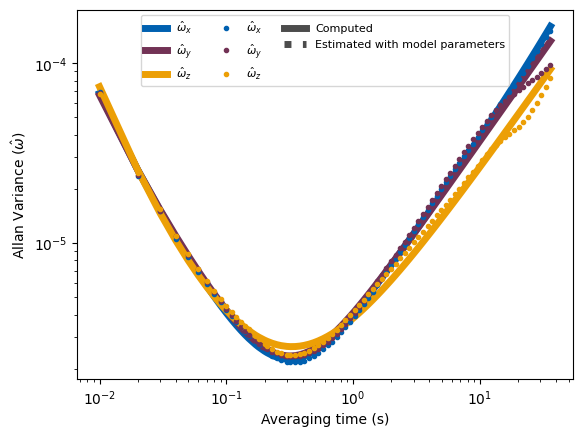

In [334]:
# DISIMU, omega hat
tau_wx, avar_wx = allan_variance.compute_avar(state_est_hist[:,0], dt)
tau_wy, avar_wy = allan_variance.compute_avar(state_est_hist[:,1], dt)
tau_wz, avar_wz = allan_variance.compute_avar(state_est_hist[:,2], dt)
params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
print(f"DISIMU omega hat: {params_wx}, {params_wy}, {params_wz}")

# Computed
fig, ax = plt.subplots()
plt.loglog(tau_wx, avar_pred_wx, label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_pred_wy, label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_pred_wz, label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_wx, avar_wx, '.', label="$\hat{\omega}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_wy, avar_wy, '.', label="$\hat{\omega}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_wz, avar_wz, '.', label="$\hat{\omega}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 1])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

IMU 1 SF hat: quantization    0.00000000000000
white           0.00112456568040
flicker         0.00000000000000
walk            0.00224986072839
ramp            0.00024396859048
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00111754095416
flicker         0.00117139071145
walk            0.00219506050800
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00003299307509
white           0.00103684143892
flicker         0.00160699564133
walk            0.00149894329987
ramp            0.00000000000000
Name: 0, dtype: float64
IMU 2 SF hat: quantization    0.00000000000000
white           0.00112358515444
flicker         0.00027569963223
walk            0.00219348115698
ramp            0.00031786020633
Name: 0, dtype: float64, quantization    0.00002320031013
white           0.00108962805515
flicker         0.00118830292875
walk            0.00166165740184
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00002

Text(0, 0.5, 'Allan Variance ($\\hat{\\omega}$)')

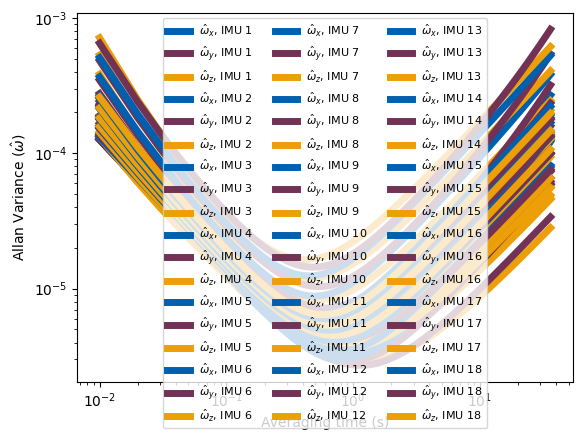

In [335]:
# individual IMUs, omega hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_wx, avar_wx = allan_variance.compute_avar(meas_hist[:,j*6], dt)
    tau_wy, avar_wy = allan_variance.compute_avar(meas_hist[:,j*6+1], dt)
    tau_wz, avar_wz = allan_variance.compute_avar(meas_hist[:,j*6+2], dt)
    params_wx, avar_pred_wx = allan_variance.estimate_parameters(tau_wx, avar_wx)
    params_wy, avar_pred_wy = allan_variance.estimate_parameters(tau_wy, avar_wy)
    params_wz, avar_pred_wz = allan_variance.estimate_parameters(tau_wz, avar_wz)
    print(f"IMU {j+1} SF hat: {params_wx}, {params_wy}, {params_wz}")

    # Estimated
    plt.loglog(tau_wx, avar_pred_wx, '-', label="$\hat{\omega}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_wy, avar_pred_wy, '-', label="$\hat{\omega}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_wz, avar_pred_wz, '-', label="$\hat{\omega}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([1e-8, 1])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{\omega}$)")

DISIMU SF hat: quantization    0.00000000000000
white           0.00113025723038
flicker         0.00012594819043
walk            0.00237027293743
ramp            0.00031712688909
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00112201329249
flicker         0.00110188612532
walk            0.00232500949335
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00002856247577
white           0.00102871827403
flicker         0.00193201960668
walk            0.00192462612593
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

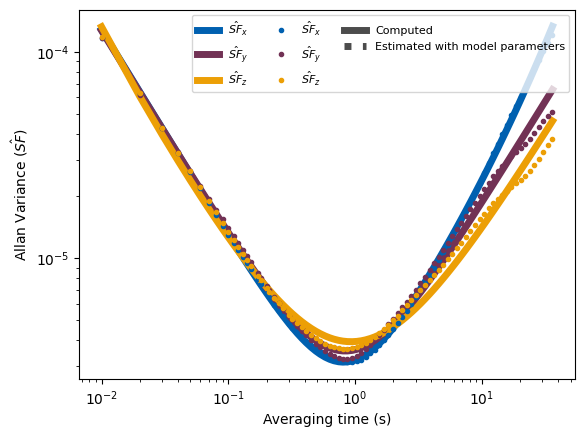

In [336]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(state_est_hist[:,6], dt)
tau_fy, avar_fy = allan_variance.compute_avar(state_est_hist[:,7], dt)
tau_fz, avar_fz = allan_variance.compute_avar(state_est_hist[:,8], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

IMU 1 SF hat: quantization    0.00003379270858
white           0.00058104152496
flicker         0.00000000000000
walk            0.00330857119082
ramp            0.00021212159273
Name: 0, dtype: float64, quantization    0.00003222954071
white           0.00059319336343
flicker         0.00031227411003
walk            0.00332746669186
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00004019754384
white           0.00049595421375
flicker         0.00152312702691
walk            0.00276225485321
ramp            0.00000000000000
Name: 0, dtype: float64/n
IMU 2 SF hat: quantization    0.00003379270858
white           0.00058104152496
flicker         0.00000000000000
walk            0.00330857119082
ramp            0.00021212159273
Name: 0, dtype: float64, quantization    0.00003222954071
white           0.00059319336343
flicker         0.00031227411003
walk            0.00332746669186
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.000

Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

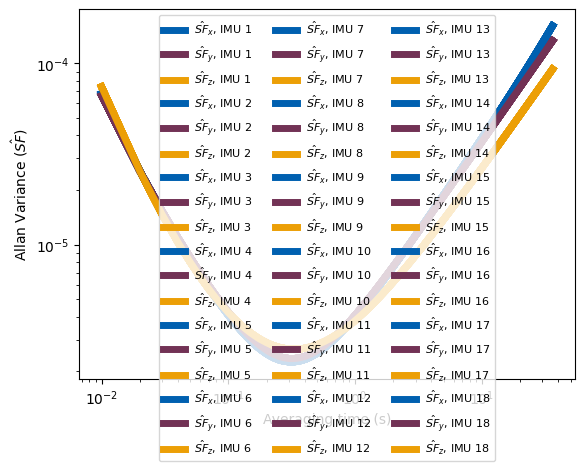

In [337]:
# individual IMUs, SF hat
fig, ax = plt.subplots()
for j in range(num_imus):
    tau_fx, avar_fx = allan_variance.compute_avar(meas_hist[:,j*6+3], dt)
    tau_fy, avar_fy = allan_variance.compute_avar(meas_hist[:,j*6+4], dt)
    tau_fz, avar_fz = allan_variance.compute_avar(meas_hist[:,j*6+5], dt)
    params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
    params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
    params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
    print(f"IMU {j+1} SF hat: {params_fx}, {params_fy}, {params_fz}/n")

    # Estimated
    plt.loglog(tau_fx, avar_pred_fx, '-', label="$\hat{SF}_x$"+f", IMU {j+1}", linewidth=5, color = "#0060B0")
    plt.loglog(tau_fy, avar_pred_fy, '-', label="$\hat{SF}_y$"+f", IMU {j+1}", linewidth=5, color = "#723255")
    plt.loglog(tau_fz, avar_pred_fz, '-', label="$\hat{SF}_z$"+f", IMU {j+1}", linewidth=5, color = "#EC9F06")

# ax.set_ylim([0.00000001, 0.01])
plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper center')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

Text(0, 0.5, '$\\hat{\\omega}$ ($^{o}/s$)')

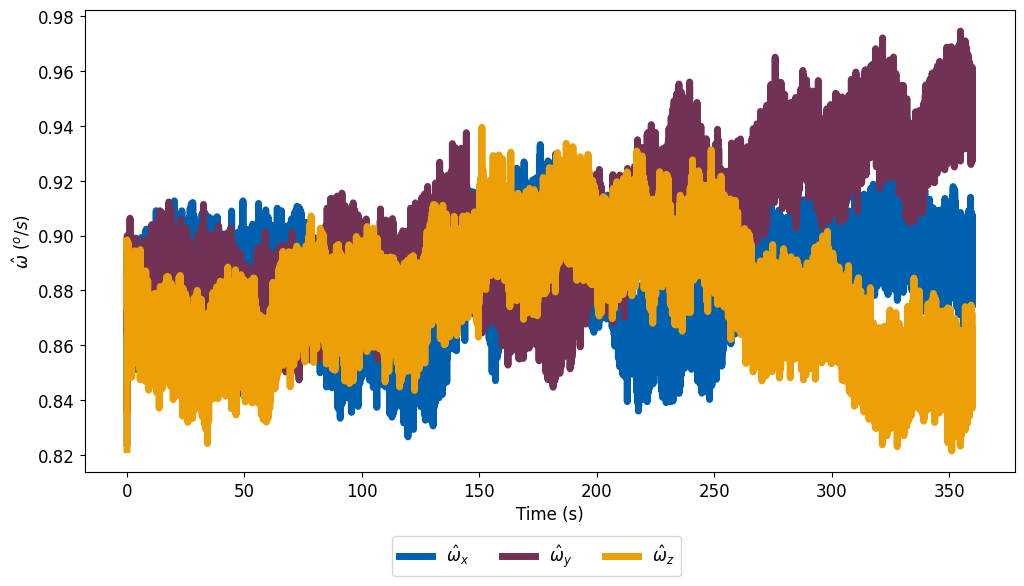

In [338]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax1.plot(time[:], state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax1.plot(time[:], state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\omega}$ ($^{o}/s$)", fontsize=12)

Text(0.5, 0, 'Time (s)')

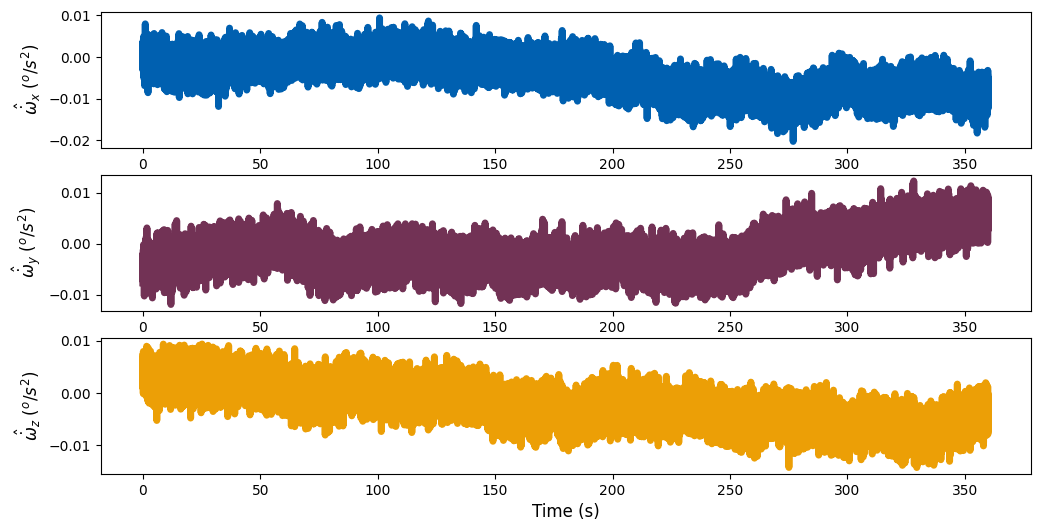

In [339]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,3])
# plt.plot(time, state_est_hist[:,4])
# plt.plot(time, state_est_hist[:,5])
# plt.title("omega dot")

fig2, ax2 = plt.subplots(3, 1, figsize = (12, 6))
ax2[0].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
# ax2[0].set_ylim([-0.0005, 0.0005])
# ax2[1].set_ylim([-0.0005, 0.0005])
# ax2[2].set_ylim([-0.0005, 0.0005])
ax2[0].set_ylabel("$\hat{\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1].set_ylabel("$\hat{\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2].set_ylabel("$\hat{\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

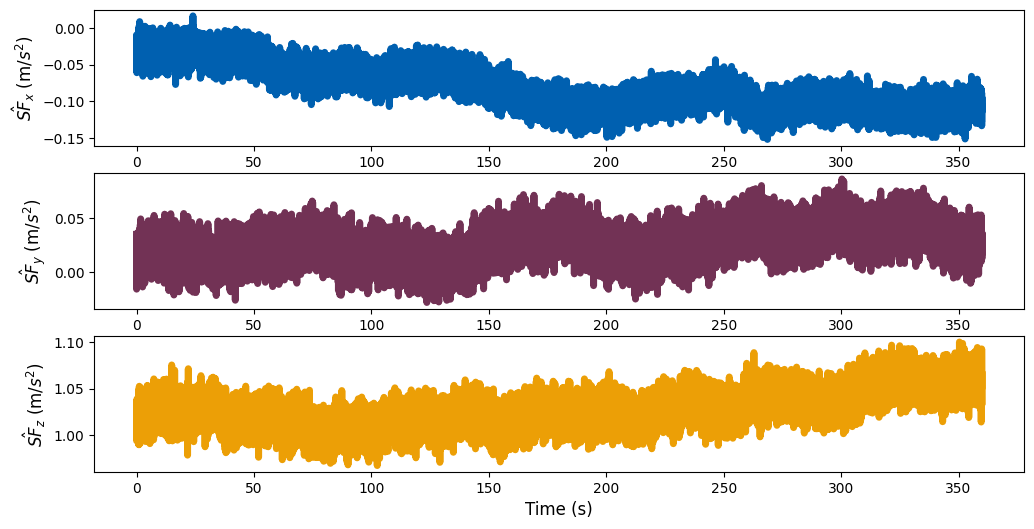

In [340]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_est_hist[:,6])
# plt.plot(time, state_est_hist[:,7])
# plt.plot(time, state_est_hist[:,8])
# plt.title("specific force")

fig3, ax3 = plt.subplots(3, 1, figsize = (12, 6))
ax3[0].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax3[1].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax3[2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
# ax3[0].set_ylim([-0.005, 0.005])
# ax3[1].set_ylim([-0.005, 0.005])
# ax3[2].set_ylim([-0.005, 0.005])
ax3[0].set_ylabel("$\hat{SF}_x$ (m/$s^2$)", fontsize=12)
ax3[1].set_ylabel("$\hat{SF}_y$ (m/$s^2$)", fontsize=12)
ax3[2].set_ylabel("$\hat{SF}_z$ (m/$s^2$)", fontsize=12)
ax3[2].set_xlabel("Time (s)", fontsize=12)

Text(0, 0.5, '$\\omega$ ($^{o}/s$)')

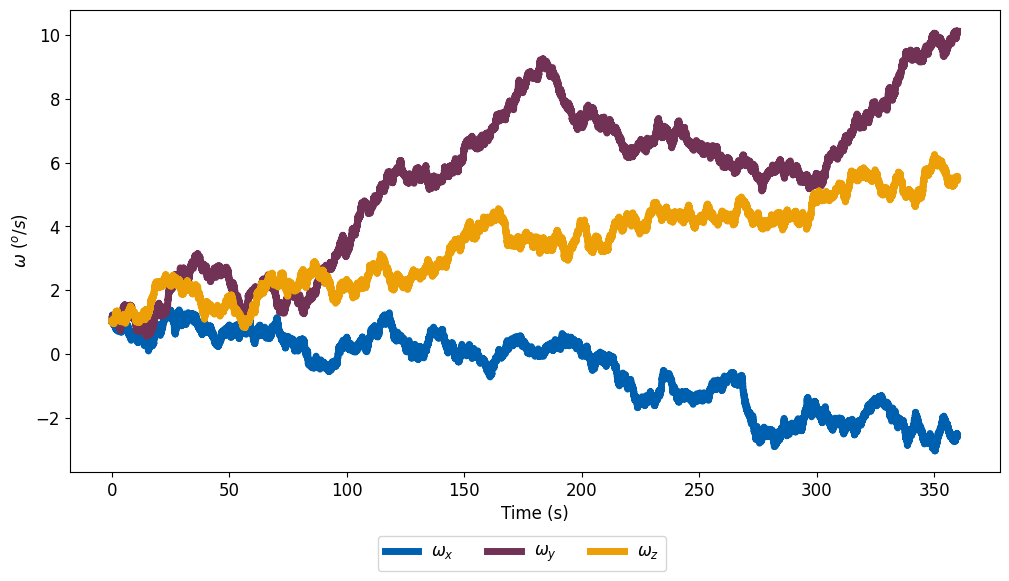

In [341]:
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,0])
# plt.plot(time, state_hist[:,1])
# plt.plot(time, state_hist[:,2])
# plt.title("omega")

fig4, ax4 = plt.subplots(figsize = (12, 6))
ax4.plot(time[10:], state_hist[10:,0], linewidth=5, color = "#0060B0", label = "$\omega_x$")
ax4.plot(time[10:], state_hist[10:,1], linewidth=5, color = "#723255", label = "$\omega_y$")
ax4.plot(time[10:], state_hist[10:,2], linewidth=5, color = "#EC9F06", label = "$\omega_z$")
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax4.set_xlabel("Time (s)", fontsize=12)
# ax4.set_ylim([1-0.005, 1+0.005])
ax4.set_ylabel("$\omega$ ($^{o}/s$)", fontsize=12)

Text(0.5, 0, 'Time (s)')

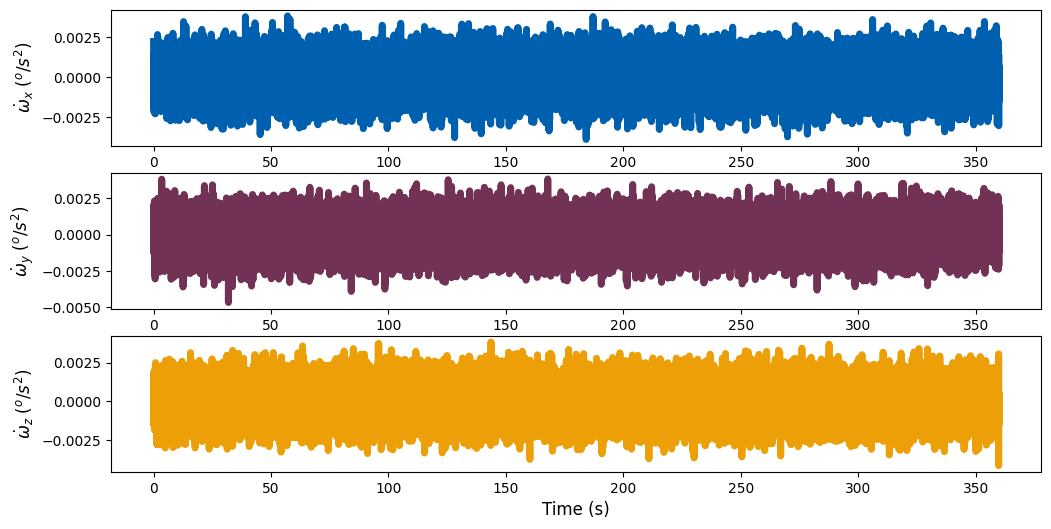

In [342]:
# system, omega hat dot
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,3])
# plt.plot(time, state_hist[:,4])
# plt.plot(time, state_hist[:,5])
# plt.title("omega dot")

fig5, ax5 = plt.subplots(3, 1, figsize = (12, 6))
ax5[0].plot(time, state_hist[:,3], linewidth=5, color = "#0060B0", label = "$\dot{\omega}_x$")
ax5[1].plot(time, state_hist[:,4], linewidth=5, color = "#723255", label = "$\dot{\omega}_y$")
ax5[2].plot(time, state_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\dot{\omega}_z$")
ax5[0].set_ylabel("$\dot{\omega}_x$ ($^{o}/s^2$)", fontsize=12)
ax5[1].set_ylabel("$\dot{\omega}_y$ ($^{o}/s^2$)", fontsize=12)
ax5[2].set_ylabel("$\dot{\omega}_z$ ($^{o}/s^2$)", fontsize=12)
ax5[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

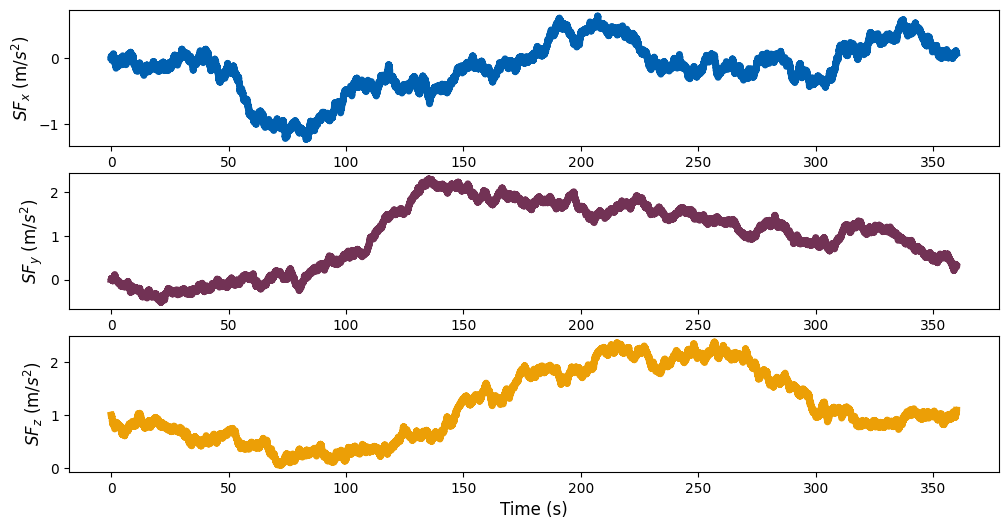

In [343]:
# dynamics, SF
# plt.figure(figsize = (12, 6))
# plt.plot(time, state_hist[:,6])
# plt.plot(time, state_hist[:,7])
# plt.plot(time, state_hist[:,8])
# plt.title("specific force")

fig6, ax6 = plt.subplots(3, 1, figsize = (12, 6))
ax6[0].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$SF_x$")
ax6[1].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$SF_y$")
ax6[2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$SF_z$")
# ax3[0].set_ylim([-0.0025, 0.0025])
# ax3[1].set_ylim([-0.0025, 0.0025])
# ax3[2].set_ylim([-0.0025, 0.0025])
# ax6[0].set_ylim([-0.005, 0.005])
# ax6[1].set_ylim([-0.005, 0.005])
# ax6[2].set_ylim([-0.005, 0.005])
ax6[0].set_ylabel("$SF_x$ (m/$s^2$)", fontsize=12)
ax6[1].set_ylabel("$SF_y$ (m/$s^2$)", fontsize=12)
ax6[2].set_ylabel("$SF_z$ (m/$s^2$)", fontsize=12)
ax6[2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

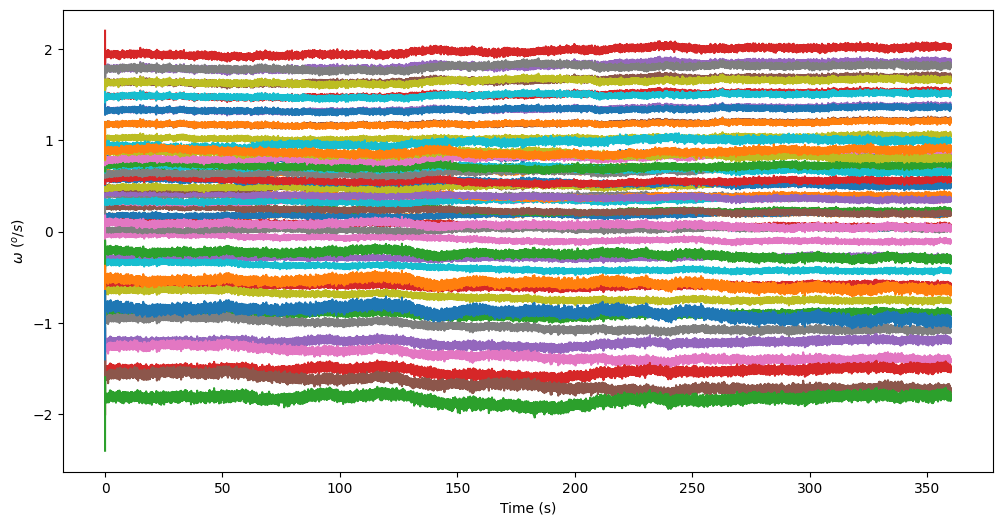

In [344]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

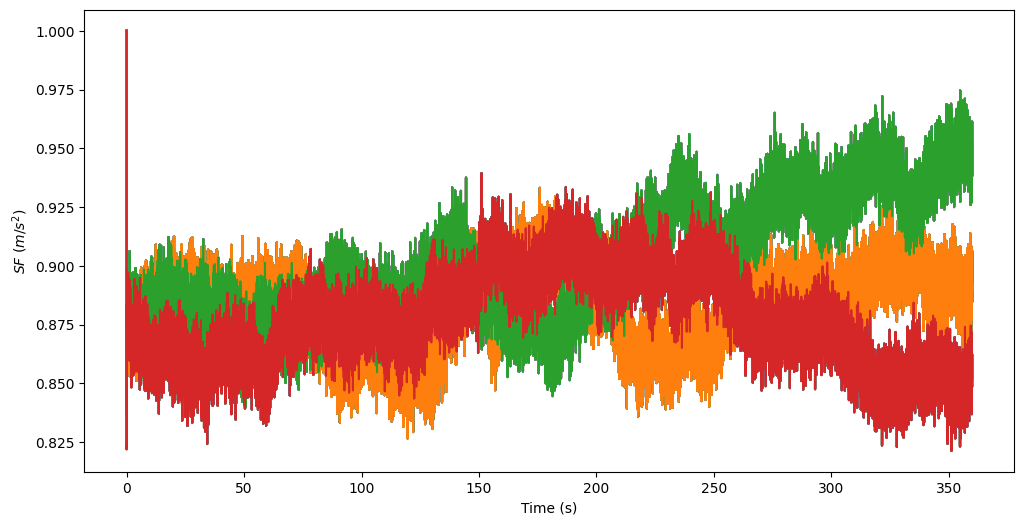

In [345]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])
plt.ylabel("$SF$ ($m/s^2$)")
plt.xlabel("Time (s)")